In [1]:
import nltk
import numpy as np
import pandas as pd
import argparse
import string
import re
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

stemmer = nltk.stem.PorterStemmer()

In [2]:
#file_path = 'job_postings_salary.txt'  // Mansheel's file path
file_path = 'job_postings_salary.csv'
all_postings = pd.read_csv(file_path)

all_postings.head()

,combined_text,annual_salary,salary_range,salary_bin
0,Hearing Care Provider Overview\n\nHearingLife ...,63000.0,50k-100k,1
1,Cook descriptionTitle\n\n Looking for a great ...,46321.6,0-50k,0
2,Principal Cloud Security Architect (Remote) Jo...,240895.0,150k+,3
3,"Dishwasher descriptionTitle\n\n $2,000 Sign-on...",40144.0,0-50k,0
4,Insights Analyst - Auto Industry Who We Are\n\...,61000.0,50k-100k,1


In [3]:
# define initial stop words
closed_class_stop_words = ['a','the','an','and','or','but','about','above','after','along','amid','among',\
                           'as','at','by','for','from','in','into','like','minus','near','of','off','on',\
                           'onto','out','over','past','per','plus','since','till','to','under','until','up',\
                           'via','vs','with','that','can','cannot','could','may','might','must',\
                           'need','ought','shall','should','will','would','have','had','has','having','be',\
                           'is','am','are','was','were','being','been','get','gets','got','gotten',\
                           'getting','seem','seeming','seems','seemed',\
                           'enough', 'both', 'all', 'your' 'those', 'this', 'these', \
                           'their', 'the', 'that', 'some', 'our', 'no', 'neither', 'my',\
                           'its', 'his' 'her', 'every', 'either', 'each', 'any', 'another',\
                           'an', 'a', 'just', 'mere', 'such', 'merely' 'right', 'no', 'not',\
                           'only', 'sheer', 'even', 'especially', 'namely', 'as', 'more',\
                           'most', 'less' 'least', 'so', 'enough', 'too', 'pretty', 'quite',\
                           'rather', 'somewhat', 'sufficiently' 'same', 'different', 'such',\
                           'when', 'why', 'where', 'how', 'what', 'who', 'whom', 'which',\
                           'whether', 'why', 'whose', 'if', 'anybody', 'anyone', 'anyplace', \
                           'anything', 'anytime' 'anywhere', 'everybody', 'everyday',\
                           'everyone', 'everyplace', 'everything' 'everywhere', 'whatever',\
                           'whenever', 'whereever', 'whichever', 'whoever', 'whomever' 'he',\
                           'him', 'his', 'her', 'she', 'it', 'they', 'them', 'its', 'their','theirs',\
                           'you','your','yours','me','my','mine','I','we','us','much','and/or'
                           ]
stop_words = set([*nltk.corpus.stopwords.words('english'),
                *closed_class_stop_words])

### Create a Word Cloud to pick out non-insightful words in this specific dataset

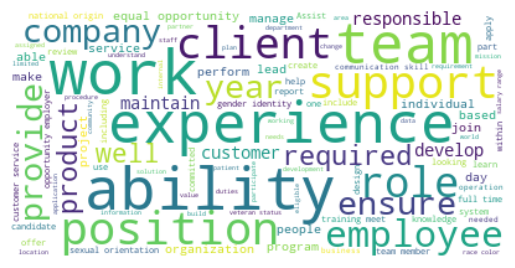

In [4]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

text = " ".join(description for description in all_postings['combined_text'])



wordcloud = WordCloud(stopwords = stop_words,max_font_size=50, max_words=100, background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



'company', 'ability', 'experience', 'year', 'work', 'position', 'employee' are common in every job postings. 
Words such as 'nation','origin','experi', 'opportun','sexual', 'orient', 'race', 'vetaran' are common in job postings' description as Equal Opportunity Employer and can be omitted

In [5]:
# add to stop words
stop_words.update(['company', 'ability', 'experience', 'year', 'job', 'hour',
                    'years', 'work', 'position','work', 'nation','origin', 
                    'opportunity','sexual', 'orient', 'race', 'vetaran', 'requires', 'employee'])


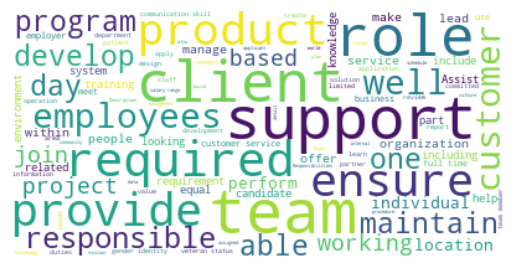

In [6]:
# word cloud after adding more stop words
wordcloud = WordCloud(stopwords = stop_words,max_font_size=50, max_words=100, background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [7]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F700-\U0001F77F"  
                           u"\U0001F780-\U0001F7FF"  
                           u"\U0001F800-\U0001F8FF"  
                           u"\U0001F900-\U0001F9FF"  
                           u"\U0001FA00-\U0001FA6F"  
                           u"\U0001FA70-\U0001FAFF"  
                           u"\U00002702-\U000027B0"  
                           u"\U000024C2-\U0001F251" 
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [8]:
def preprocess_text(text):
    text_no_emojis = remove_emojis(text)
    tokens = word_tokenize(text_no_emojis)
    processed_tokens = [stemmer.stem(token.lower()) for token in tokens 
                        if token.lower() not in stop_words and token not in string.punctuation]
    return ' '.join(processed_tokens)

In [9]:
all_postings['processed_description'] = all_postings['combined_text'].apply(preprocess_text)

print(all_postings[['combined_text', 'processed_description']].head())


                                       combined_text  \
0  Hearing Care Provider Overview\n\nHearingLife ...   
1  Cook descriptionTitle\n\n Looking for a great ...   
2  Principal Cloud Security Architect (Remote) Jo...   
3  Dishwasher descriptionTitle\n\n $2,000 Sign-on...   
4  Insights Analyst - Auto Industry Who We Are\n\...   

                               processed_description  
0  hear care provid overview hearinglif nation he...  
1  cook descriptiontitl look great develop profes...  
2  princip cloud secur architect remot summari ih...  
3  dishwash descriptiontitl 2,000 sign-on bonu gu...  
4  insight analyst auto industri escal award-win ...  


In [10]:
# create processed_description csv
all_postings.to_csv('processed_description.csv', index=False)


### Split validation, training and test set

In [11]:
# define target class and input text
target = all_postings['salary_bin'].astype('category')
text = all_postings['processed_description']

In [12]:
from sklearn.model_selection import train_test_split
# split data into 70% training, 10% validation and 20% testing set
tfidf = TfidfVectorizer().fit(text)
X_tfidf =  tfidf.transform(text)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, target, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125)


### TF-IDF Vectorization

In [13]:
# map salary bin to range
salary_info = {all_postings.salary_bin.unique()[i]: all_postings.salary_range.unique()[i] for i in range(len(all_postings.salary_bin.unique()))}
print(salary_info)

{1: '50k-100k', 0: '0-50k', 3: '150k+', 2: '100k-150k'}


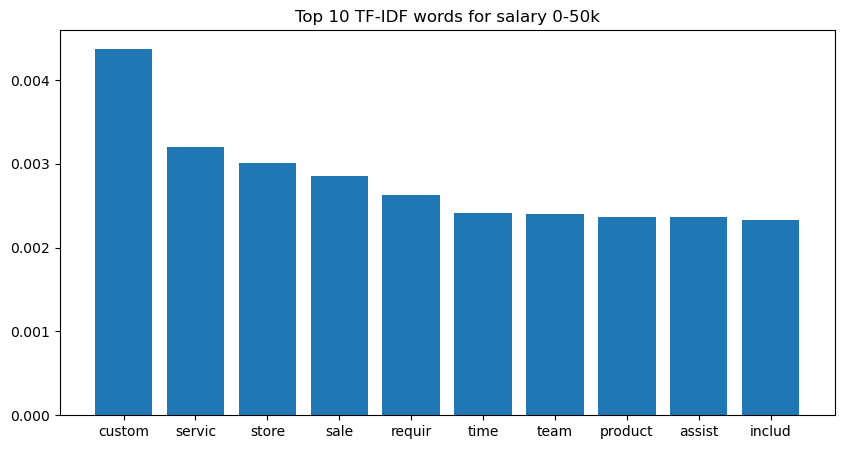

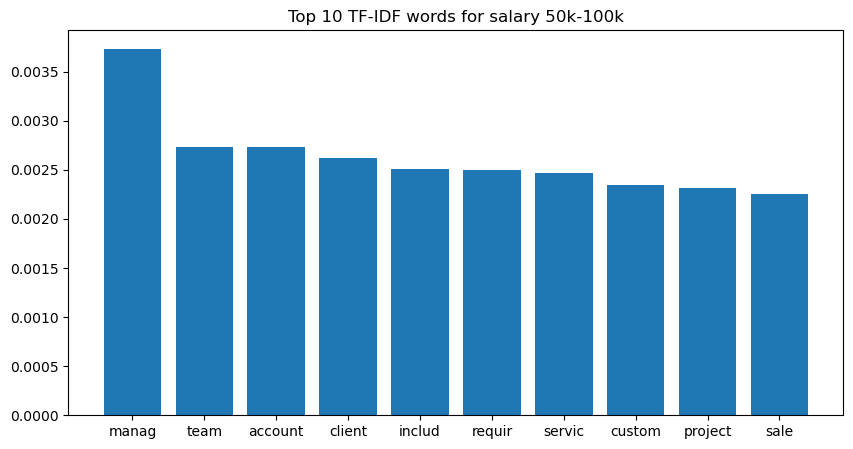

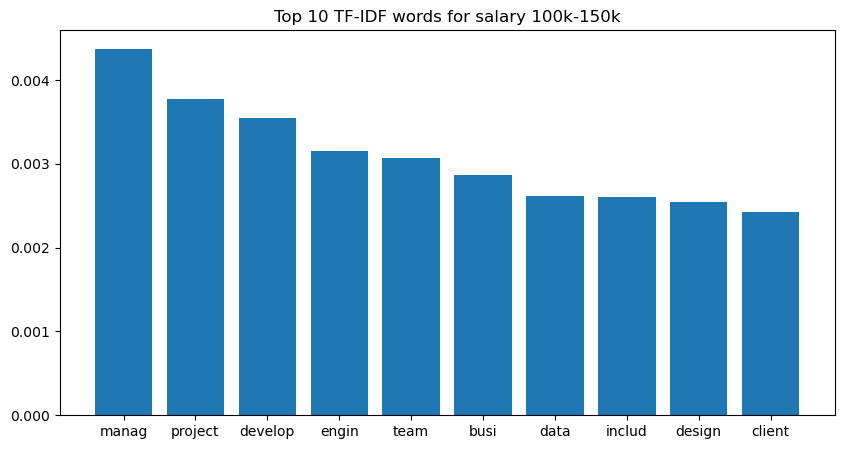

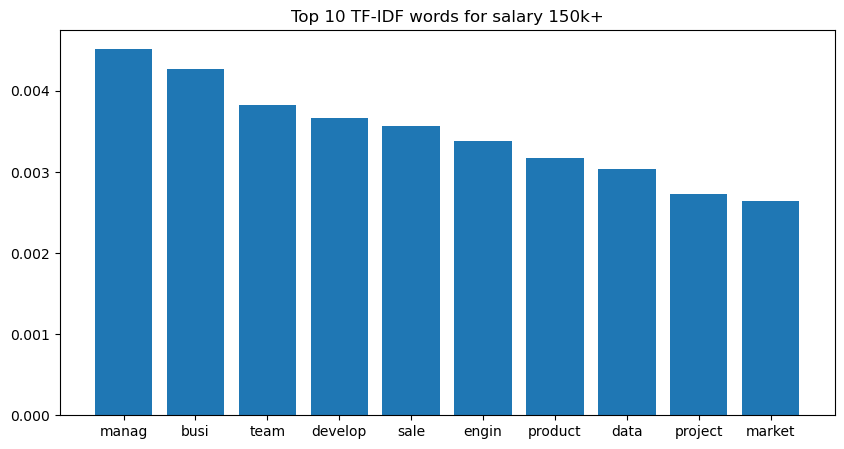

In [14]:
# graph top 10 tfidf words in each salary bin
import matplotlib.pyplot as plt


for salary_bin in target.cat.categories:
    X_train_bin = X_train[y_train == salary_bin]
    tfidf_sum = np.asarray(X_train_bin.sum(axis=0)).flatten()
    tfidf_sum = tfidf_sum / tfidf_sum.sum()
    sorted_idx = np.argsort(tfidf_sum)[::-1]
    feature_names = np.array(tfidf.get_feature_names_out())
    top_idx = sorted_idx[:10]
    top_values = tfidf_sum[top_idx]
    top_words = feature_names[top_idx]
    plt.figure(figsize=(10, 5))
    plt.bar(top_words, top_values)
    plt.title(f'Top 10 TF-IDF words for salary {salary_info.get(salary_bin)}')
    plt.show()

## ML Models 
### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score, f1_score



# tune the hyperparameter C using the validation set
C_values = [0.01, 0.1, 1, 10, 100]
val_accuracy = []
for C in C_values:
    logistic_regression = LogisticRegression(C=C, max_iter=1000, penalty='l2',multi_class='ovr')
    logistic_regression.fit(X_val, y_val)
    
    y_val_pred = logistic_regression.predict(X_val)
    val_accuracy.append(accuracy_score(y_val, y_val_pred))

best_C = C_values[np.argmax(val_accuracy)]

# fit the model on the training set using the best C
logistic_regression = LogisticRegression(C=C, max_iter=1000, penalty='l2',  multi_class='ovr')
logistic_regression.fit(X_train, y_train)


# evaluate the model on the test set
y_test_pred = logistic_regression.predict(X_test)
y_test_pred_proba = logistic_regression.predict_proba(X_test)


logreg_f1 = f1_score(y_test, y_test_pred, average='weighted')
logreg_auc = roc_auc_score(y_test, y_test_pred_proba, average='weighted', multi_class='ovr')

print(f'Logistic Regression F1 Score: {logreg_f1}')
print(f'Logistic Regression AUC Score: {logreg_auc}')



Logistic Regression F1 Score: 0.6918831984198417
Logistic Regression AUC Score: 0.8751212310274334


### SVM

In [16]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score

class_weight = dict(all_postings['salary_bin'].value_counts(normalize=True))
# tune the hyperparameter C using the validation set
C_values = [0.01, 0.1, 1, 10, 100]
val_accuracy = []
for C in C_values:
    svm = LinearSVC(C=C, max_iter=10000, class_weight=class_weight,)
    svm.fit(X_val, y_val)
    
    y_val_pred = svm.predict(X_val)
    val_accuracy.append(accuracy_score(y_val, y_val_pred))

best_C = C_values[np.argmax(val_accuracy)]

# fit the model on the training set using the best C
svm = LinearSVC(C=best_C, max_iter=10000, class_weight=class_weight)
svm.fit(X_train, y_train)

# evaluate the model on the test set
y_test_pred = svm.predict(X_test)


svm_f1 = f1_score(y_test, y_test_pred, average='weighted')
svm_auc = roc_auc_score(y_test, y_test_pred_proba, average='weighted', multi_class='ovr')
print(f'Linear SVC F1 Score: {svm_f1}')
print(f'Linear SVC AUC Score: {svm_auc}')



/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/krysten/a

Linear SVC F1 Score: 0.67634181684857
Linear SVC AUC Score: 0.8751212310274334


### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
clf = RandomForestClassifier(n_estimators=1000, max_depth=50, bootstrap=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))
print('AUC Score: ', roc_auc_score(y_test, clf.predict_proba(X_test), average='weighted', multi_class='ovr'))





Accuracy:  0.6258426966292134
F1 Score:  0.6046425109442652
AUC Score:  0.8757318885621388


### AdaBoost

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
clf = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))
print('AUC Score: ', roc_auc_score(y_test, clf.predict_proba(X_test), average='weighted', multi_class='ovr'))


Accuracy:  0.6097378277153558
F1 Score:  0.6036896391620549
AUC Score:  0.7558082111252612
